In [2]:
# we want to load in a pretrained resnet model.
# we want to use the ImageFolder format specified by PyTorch
# we freeze the resnet parameters and train on our new dataset.
# train and evaluate

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
from PIL.Image import BILINEAR
from torchinfo import summary
from transformers import (
    AutoImageProcessor,
    TrainingArguments,
    Trainer,
    EfficientNetConfig,
    EfficientNetForImageClassification,
    ViTForImageClassification,
    AutoTokenizer,
    EfficientNetImageProcessor,
    ViTImageProcessor,
)
import peft
import evaluate
import accelerate
import cv2


cudnn.benchmark = True
plt.ion()   # interactive mode

/Users/rijudey/Documents/GitHub/AppliedComputerVision/diningHallEnv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/rijudey/Documents/GitHub/AppliedComputerVision/diningHallEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# For straightforward datasets, sometimes you can make do with built-in PyTorch dataset objects.
# We want to apply automated data augmentations, which will be different for the training
# and eval scenarios

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

In [5]:
data_dir = "../../data/dataset/"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print(class_names)

print(image_datasets.keys())
print("label", image_datasets['train'][0][1])
# we will use this test image to do all our preliminary testing to make sure stuff works.
test_image = image_datasets['train'][0][0]
test_image = test_image.unsqueeze(0)
test_image.mean(), test_image.std(), test_image.shape

['1', '2', '3', '4', '5']
dict_keys(['train', 'val'])
label 0


(tensor(0.3929), tensor(0.2438), torch.Size([1, 3, 224, 224]))

In [6]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x[0] for x in batch]),
        "labels": torch.LongTensor([int(x[1]) for x in batch]),
    }

## Load ViT Model

In [7]:
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=5,
    ignore_mismatched_sizes=True,
    output_attentions = True
)
vit

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
inputs = image_processor(images = test_image, return_tensors = 'pt')

print(inputs.keys())

output = vit(**inputs)





dict_keys(['pixel_values'])


In [9]:
test_image.squeeze(0).size()

torch.Size([3, 224, 224])

In [16]:
print(output.attentions[0].shape)
att_mat = output.attentions[0]
att_mat = torch.mean(att_mat, dim=1) #taking average of attention across all heads

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

print(aug_att_mat.shape)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
print("joint attentions shape:", joint_attentions.shape)

print("shape of augmented attention matrix:", aug_att_mat.size())
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

print(joint_attentions[0])
# Attention from the output token to the input space.
v = joint_attentions[-1]

print("values of v", v)
print("shape of v", v.shape)
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
print("grid size", grid_size)
attention_map = mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
print("attention map is", attention_map)
mask = cv2.resize(mask / mask.max(), (224,224))[..., np.newaxis]
mask = mask = np.repeat(mask, 3, axis=-1)  # Replicate mask across channels
mask = np.transpose(mask, (2, 0, 1))  # Transpose mask to match the order of dimensions in test_image
result = (mask * test_image.squeeze(0).numpy()).astype("uint8")

print(result[0])




torch.Size([1, 12, 197, 197])
torch.Size([1, 197, 197])
joint attentions shape: torch.Size([1, 197, 197])
shape of augmented attention matrix: torch.Size([1, 197, 197])
tensor([[0.8279, 0.0014, 0.0012,  ..., 0.0011, 0.0012, 0.0014],
        [0.1000, 0.5470, 0.0055,  ..., 0.0015, 0.0015, 0.0016],
        [0.0984, 0.0052, 0.5468,  ..., 0.0014, 0.0014, 0.0017],
        ...,
        [0.0985, 0.0016, 0.0014,  ..., 0.5459, 0.0043, 0.0048],
        [0.0996, 0.0016, 0.0013,  ..., 0.0043, 0.5462, 0.0051],
        [0.1010, 0.0016, 0.0015,  ..., 0.0044, 0.0048, 0.5469]],
       grad_fn=<SelectBackward0>)
values of v tensor([[0.8279, 0.0014, 0.0012,  ..., 0.0011, 0.0012, 0.0014],
        [0.1000, 0.5470, 0.0055,  ..., 0.0015, 0.0015, 0.0016],
        [0.0984, 0.0052, 0.5468,  ..., 0.0014, 0.0014, 0.0017],
        ...,
        [0.0985, 0.0016, 0.0014,  ..., 0.5459, 0.0043, 0.0048],
        [0.0996, 0.0016, 0.0013,  ..., 0.0043, 0.5462, 0.0051],
        [0.1010, 0.0016, 0.0015,  ..., 0.0044, 0.0048,

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
print(mask[0].shape)
ax1.set_title('Original')
ax2.set_title('Attention Map')
ax1.imshow(test_image.squeeze(0).permute(1, 2, 0))
ax2.imshow(mask[0], cmap="viridis")

## LoRa FineTuning for ViT

In [ ]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(vit, config)
model.print_trainable_parameters()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


shape of image (3, 224, 224)
ImageClassifierOutput(loss=None, logits=tensor([[ 0.1576, -0.4492,  0.3942,  0.8287, -0.5118]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


  0%|          | 0/100 [00:00<?, ?it/s]

inputs shape (10, 224, 224, 3)


 10%|█         | 10/100 [00:01<00:14,  6.06it/s]

inputs shape (10, 224, 224, 3)


 20%|██        | 20/100 [00:03<00:13,  5.89it/s]

inputs shape (10, 224, 224, 3)


 30%|███       | 30/100 [00:05<00:11,  5.89it/s]

inputs shape (10, 224, 224, 3)


 40%|████      | 40/100 [00:07<00:10,  5.51it/s]

inputs shape (10, 224, 224, 3)


 50%|█████     | 50/100 [00:09<00:09,  5.18it/s]

inputs shape (10, 224, 224, 3)


 68%|██████▊   | 68/100 [00:15<00:08,  3.97it/s]

inputs shape (10, 224, 224, 3)


 71%|███████   | 71/100 [00:19<00:10,  2.72it/s]

inputs shape (10, 224, 224, 3)


 80%|████████  | 80/100 [00:21<00:06,  3.15it/s]

inputs shape (10, 224, 224, 3)


 90%|█████████ | 90/100 [00:23<00:02,  3.49it/s]

inputs shape (10, 224, 224, 3)


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


temp shape: (224, 224, 3)
mask shape (224, 224)


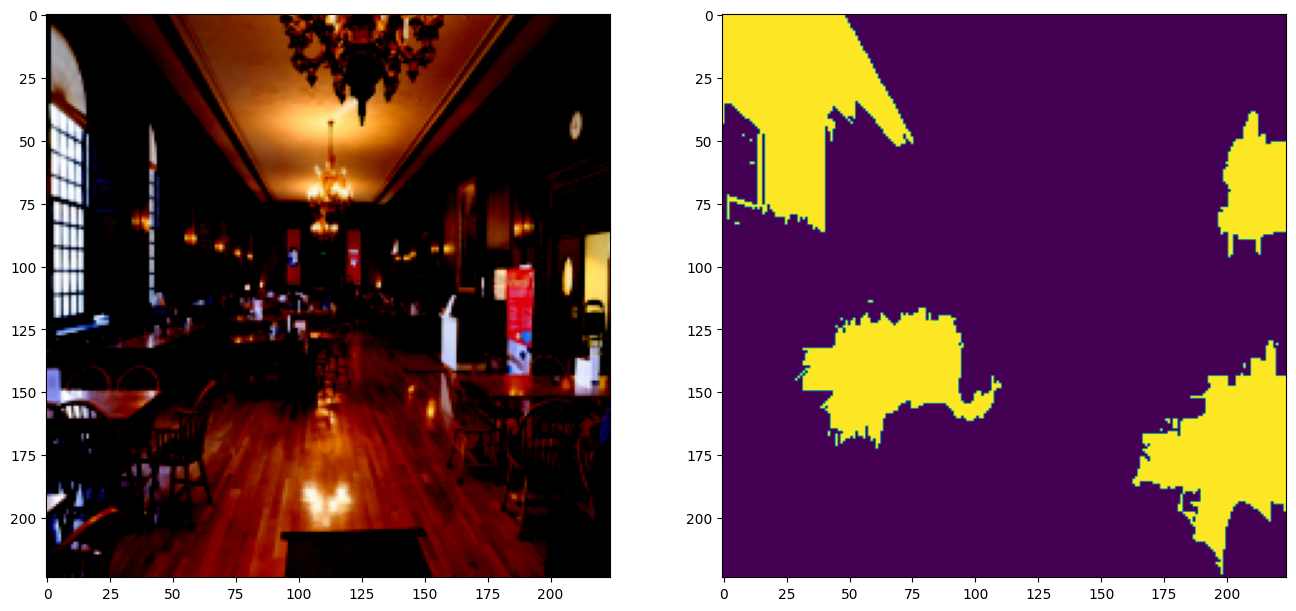

In [42]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=5,
    ignore_mismatched_sizes=True
)

# Load an example image
example_image = Image.open("../../data/dataset/train/1/File 00008.jpg")
inputs = image_processor(images = example_image, return_tensors = 'pt')
example_tensor = inputs['pixel_values'].squeeze(0)

print("shape of image", example_tensor.numpy().shape)
# Get the model prediction for the example image
model_output = vit(example_tensor.unsqueeze(0))
print(model_output)
predicted_class = torch.argmax(model_output.logits)

# Create an instance of the LIME explainer
explainer = lime_image.LimeImageExplainer()

def model_predict(inputs):
    # Convert the inputs to a PyTorch tensor
    if inputs.ndim == 3:
        inputs = inputs.unsqueeze(0)  # add a batch dimension if it doesn't exist.
    print("inputs shape", inputs.shape)  # (B, H, W, C)
    inputs = torch.from_numpy(inputs).permute(0, 3, 1, 2).float()

    # Get the model's output logits
    with torch.no_grad():
        logits = vit(inputs).logits

    # Convert the logits to probabilities
    probs = torch.softmax(logits, dim=1)

    # Return the probabilities as a NumPy array
    return probs.cpu().numpy()

# Explain the prediction
explanation = explainer.explain_instance(np.transpose(example_tensor.numpy(), (1, 2, 0)), model_predict, top_labels=5, hide_color=0, num_samples=1000)

# Get the explanation for the predicted class
idx_predicted_class = list(explanation.top_labels).index(predicted_class.item())
temp, mask = explanation.get_image_and_mask(idx_predicted_class, positive_only=True, num_features=5, hide_rest=False)

# Display the explanation
print("temp shape:", temp.shape)
print("mask shape", mask.shape)
mask_grayscale = np.mean(mask, axis = -1).astype(np.int32)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.imshow(mark_boundaries(temp, mask_grayscale))
ax2.imshow(mask)
plt.show()

### Turning off all ViT Parameters Except the Head.

In [ ]:
for p in vit.parameters():
    p.requires_grad= False

for p in vit.classifier.parameters():
    p.requires_grad = True



## ViT HuggingFace Trainer

In [ ]:
# Setup the training arguments
output_dir = "./pretrainedViT"

# we should edit things like number of training epochs and the batch size
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=100,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_num_workers=0,
#     gradient_accumulation_steps=8,
)

In [ ]:
# Compute absolute learning rate
base_learning_rate = 1e-3
total_train_batch_size = (
    training_args.train_batch_size * training_args.gradient_accumulation_steps * training_args.world_size
)

training_args.learning_rate = base_learning_rate * total_train_batch_size / 256
print("Set learning rate to:", training_args.learning_rate)

In [ ]:
# Setup a function to compute accuracy metrics
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
# Create the trainer
trainer = Trainer(
    model=vit,
    args=training_args,
    train_dataset=image_datasets['train'],
    eval_dataset=image_datasets['val'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()